In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv('/content/Training_Set_Preprocessed_Final.csv')

In [3]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [4]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 50000
Training set size: 35000
Validation set size: 7500
Testing set size: 7500


In [5]:
X_train = df_train.drop('Test Results', axis=1)
y_train = df_train['Test Results']

X_val = df_val.drop('Test Results', axis=1)
y_val = df_val['Test Results']

X_test = df_test.drop('Test Results', axis=1)
y_test = df_test['Test Results']

In [6]:
def convert_bool_strings(df):
    return df.replace({'True': True, 'False': False}).astype(int)

X_train = convert_bool_strings(X_train)
X_val = convert_bool_strings(X_val)
X_test = convert_bool_strings(X_test)

In [7]:
mlp = MLPClassifier(early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [8]:
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01]
}

In [9]:
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_mlp.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(early_stopping=True), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(100,), (50, 50)],
                         'learning_rate_init': [0.001, 0.01],
                         'solver': ['adam']},
             scoring='accuracy')

In [10]:
print("Best parameters for MLP:", grid_search_mlp.best_params_)
print("Best cross-validation accuracy for MLP:", grid_search_mlp.best_score_)

Best parameters for MLP: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best cross-validation accuracy for MLP: 0.8004


In [11]:
# 7. Evaluate on test set (NO .values used here)
y_pred = grid_search_mlp.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7978666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      2547
           1       0.75      0.75      0.75      2440
           2       0.81      0.78      0.79      2513

    accuracy                           0.80      7500
   macro avg       0.80      0.80      0.80      7500
weighted avg       0.80      0.80      0.80      7500



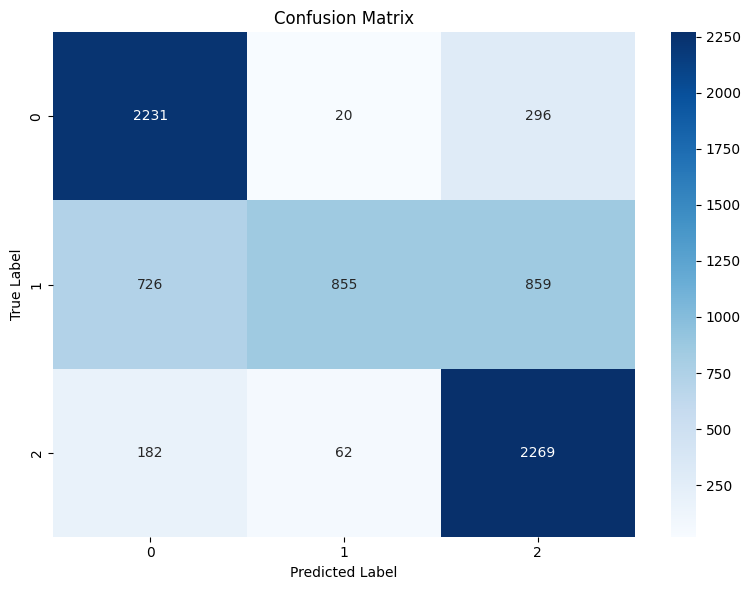

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_test = df_test['Test Results']
X_test = df_test.drop('Test Results', axis=1)
y_pred = grid_search_mlp.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = grid_search_mlp.classes_  # Get class labels from the model

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


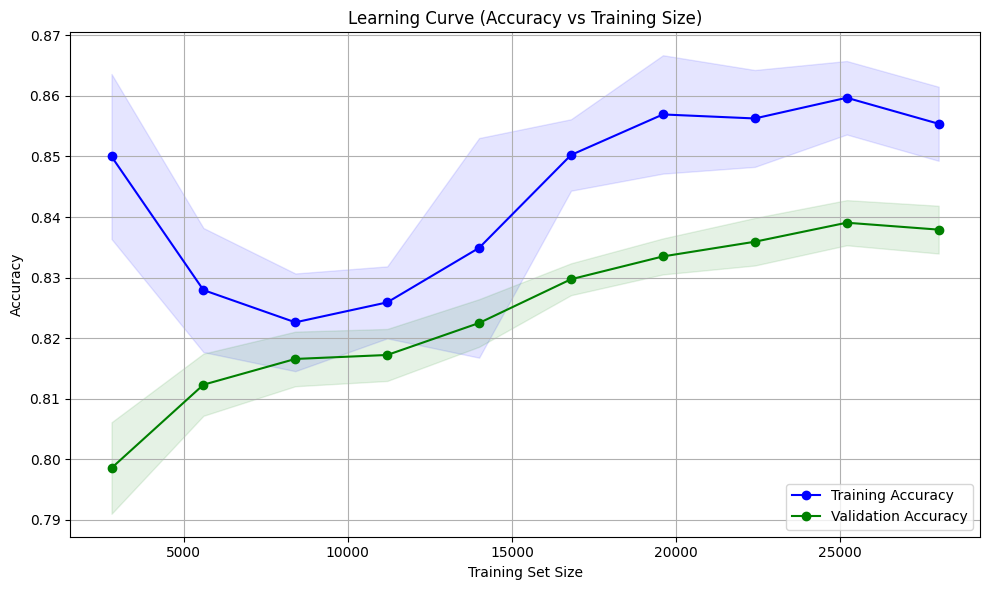

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    grid_search_mlp,
    df_train.drop('Test Results', axis=1),
    df_train['Test Results'],
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve (Accuracy vs Training Size)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
